# Clustering and PCA

### Mushroom Dataset

Podeis obtener el conjunto de datos en el siguiente enlace:

[Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification)

Como podréis comprobar, hay muchas variables, todas ellas categóricas, por lo que exploraciones con scatterplot no nos serán útiles como en otros casos.

La variable a predecir ``class`` es binaria.


In [3]:
# Carga de librerías, las que hemos considerado básicas, añadid lo que queráis :)

# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans



### Leer conjunto de datos y primer vistazo

In [4]:
# Leer el csv y sacar por pantalla las cinco primeras filas.
# Leer el archivo CSV
df = pd.read_csv('mushrooms.csv')

# Primeras filas
print(df.head())

# Dimensiones del dataset
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1       

### Exploración de datos

In [5]:
# Descripción del conjunto de datos, estándard.
# Para variables numéricas y categóricas:
print(df.describe(include='all'))

       class cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count   8124      8124        8124      8124    8124  8124            8124   
unique     2         6           4        10       2     9               2   
top        e         x           y         n       f     n               f   
freq    4208      3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8124      8124       8124  ...                     8124   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6812      5612       1728  ...                     4936   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8124                   8124      8124       8124   
unique                      9                      9         1          4   
top    

In [6]:
# Información sobre el tipo de datos de cada feature.
# Esto nos permite ver si hay columnas que no son categóricas, si hay valores nulos y el tipo de dato de cada columna.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

#### Calcular el número de nulos de cada feature

In [7]:
# Igual que otras veces, una linea, contar los nulos por variable.
# Contar valores nulos por columna
print(df.isnull().sum())

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64


#### Buscar valores extraños. Para ello, ver los valores únicos en cada feature

In [8]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# asociados (n_values).
# Buscar valores extraños: ver los valores únicos en cada feature.
# Creamos un DataFrame con dos columnas: 'feature' y 'n_values', donde 'n_values' es la lista de valores únicos de cada columna.

features = []
n_values = []

for col in df.columns:
    features.append(col)
    n_values.append(df[col].unique())

valores_unicos_df = pd.DataFrame({'feature': features, 'n_values': n_values})

print(valores_unicos_df)

                     feature                              n_values
0                      class                                [p, e]
1                  cap-shape                    [x, b, s, f, k, c]
2                cap-surface                          [s, y, f, g]
3                  cap-color        [n, y, w, g, e, p, b, u, c, r]
4                    bruises                                [t, f]
5                       odor           [p, a, l, n, f, c, y, s, m]
6            gill-attachment                                [f, a]
7               gill-spacing                                [c, w]
8                  gill-size                                [n, b]
9                 gill-color  [k, n, g, p, w, h, u, e, b, r, y, o]
10               stalk-shape                                [e, t]
11                stalk-root                       [e, c, b, r, ?]
12  stalk-surface-above-ring                          [s, f, k, y]
13  stalk-surface-below-ring                          [s, f, y

#### Tratar aquellos valores que entendamos que sean nulos


In [9]:
# Imputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.
# En el dataset de hongos, los valores nulos suelen estar representados por el carácter '?' en la columna 'stalk-root'.
# Podemos imputar esos valores con la moda (el valor más frecuente) de la columna para no perder información.

# Contar cuántos valores '?' hay en cada columna
print("Valores '?' por columna:\n", (df == '?').sum())

# Imputar la columna 'stalk-root' con la moda si tiene valores '?'
if (df['stalk-root'] == '?').any():
    moda = df['stalk-root'].mode()[0]
    df['stalk-root'] = df['stalk-root'].replace('?', moda)
    print(f"Valores '?' en 'stalk-root' reemplazados por la moda: {moda}")

# Alternativamente, si prefieres eliminar las filas con '?', puedes usar:
# df = df[df['stalk-root'] != '?']

# Comentario:
# - Imputar con la moda es útil cuando hay pocos valores nulos y no queremos perder datos.
# - Eliminar filas es útil si hay muy pocos casos y queremos máxima limpieza.

Valores '?' por columna:
 class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64
Valores '?' en 'stalk-root' reemplazados por la moda: b


#### Mirad cuántos valores hay en cada feature, ¿Todas las features aportan información? Si alguna no aporta información, eliminadla

In [10]:
# Revisamos cuántos valores únicos tiene cada columna
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")

# Identificamos columnas con un solo valor único (no aportan información)
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas a eliminar por ser constantes:", cols_to_drop)

# Eliminamos esas columnas del DataFrame
df = df.drop(columns=cols_to_drop)

# Explicación:
# - Revisamos la cantidad de valores únicos por columna para detectar columnas constantes.
# - Eliminamos las columnas que no aportan información al análisis o al modelo.


class: 2 valores únicos
cap-shape: 6 valores únicos
cap-surface: 4 valores únicos
cap-color: 10 valores únicos
bruises: 2 valores únicos
odor: 9 valores únicos
gill-attachment: 2 valores únicos
gill-spacing: 2 valores únicos
gill-size: 2 valores únicos
gill-color: 12 valores únicos
stalk-shape: 2 valores únicos
stalk-root: 4 valores únicos
stalk-surface-above-ring: 4 valores únicos
stalk-surface-below-ring: 4 valores únicos
stalk-color-above-ring: 9 valores únicos
stalk-color-below-ring: 9 valores únicos
veil-type: 1 valores únicos
veil-color: 4 valores únicos
ring-number: 3 valores únicos
ring-type: 5 valores únicos
spore-print-color: 9 valores únicos
population: 6 valores únicos
habitat: 7 valores únicos
Columnas a eliminar por ser constantes: ['veil-type']


¡Claro! Aquí tienes una explicación paso a paso, sencilla, como para niños:

---

### ¿Por qué se elimina la columna 'veil-type'?

1. **¿Qué es una columna en una tabla de datos?**  
   Imagina que tienes una tabla con información de muchos hongos. Cada columna es una característica, como el color, el tamaño, etc.

2. **¿Qué significa que una columna sea "constante"?**  
   Una columna es "constante" cuando todos los hongos tienen el mismo valor en esa columna. Es decir, no cambia nunca.

3. **¿Cómo nos dimos cuenta?**  
   Contamos cuántos valores diferentes hay en cada columna.  
   Por ejemplo:
   - Si una columna tiene 2 valores diferentes, es porque hay hongos con dos opciones distintas.
   - Si una columna tiene **solo 1 valor diferente**, es porque todos los hongos tienen exactamente lo mismo ahí.

4. **¿Qué pasó con 'veil-type'?**  
   Cuando contamos los valores únicos de cada columna, vimos esto:
   ```
   veil-type: 1 valores únicos
   ```
   Eso significa que **todos los hongos tienen el mismo 'veil-type'**.

5. **¿Por qué la eliminamos?**  
   Si una columna no cambia nunca, no nos ayuda a distinguir entre hongos diferentes.  
   Es como si todos tus amigos tuvieran el mismo color de ojos: ese dato no sirve para diferenciarlos.

6. **¿Qué hicimos?**  
   Quitamos la columna 'veil-type' de la tabla, porque no aporta información útil para el análisis.

---

**Resumen:**  
Eliminamos 'veil-type' porque siempre tiene el mismo valor. No ayuda a diferenciar hongos, así que no sirve para el análisis. Nos dimos cuenta porque al contar los valores únicos, vimos que solo había uno.

#### Separar entre variables predictoras y variables a predecir

In [11]:
# --- Separar entre variables predictoras y variables a predecir ---

# La variable objetivo es 'class', que indica si el hongo es comestible ('e') o venenoso ('p').
# Separamos la variable objetivo (y) y las variables predictoras (X).
y = df['class']  # Variable a predecir
X = df.drop(columns=['class'])  # Variables predictoras

#### Codificar correctamente las variables categóricas a numéricas

In [ ]:
# One Hot Encoder (una linea).
# Todas las variables son categóricas, así que usamos OneHotEncoder para convertirlas a variables numéricas.
# Usamos pandas.get_dummies porque es sencillo y rápido para este caso.
X_encoded = pd.get_dummies(X)
# Explicación:
# - get_dummies crea una columna binaria para cada valor posible de cada variable categórica.
# - Esto es necesario porque los modelos de machine learning de sklearn solo aceptan variables numéricas.


#### Train test split

In [14]:
# --- Train test split ---

# Dividimos el dataset en entrenamiento y test (67% train, 33% test).
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.33, random_state=42)

# Explicación:
# - Esto nos permite entrenar el modelo con una parte de los datos y evaluar su rendimiento con datos que no ha visto.

## PCA

Es un conjunto de datos del que aún no hemos visto nada (no tenemos graficas) así que vamos a hacer algunas. Tenemos el problema de que son muchas variables, **PCA al rescate**: le pedimos que nos de dos dimensiones y las pintamos, sabemos que serán **aquellas que retengan más información**.

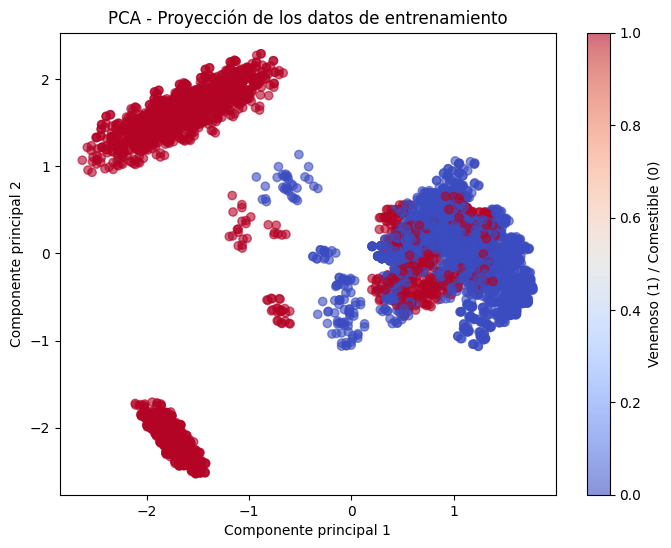

In [15]:
# PCA nos ayuda a reducir la dimensionalidad del dataset, manteniendo la mayor cantidad de información posible.
# Pedimos 2 componentes principales para poder visualizar los datos en 2D.
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Representar en un scatterplot y poner en color las etiquetas de entrenamiento
# Visualizamos los datos proyectados en 2D, coloreando según la clase real.
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=(y_train=='p'), cmap='coolwarm', alpha=0.6)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('PCA - Proyección de los datos de entrenamiento')
plt.colorbar(label='Venenoso (1) / Comestible (0)')
plt.show()

# Explicación de resultados:
# - Vemos que los puntos de diferentes clases (venenoso/comestible) tienden a agruparse en zonas separadas.
# - Esto indica que las variables originales contienen información suficiente para distinguir entre clases.
# - PCA ayuda a visualizar la separabilidad de los datos.

Parece que está bastante separadito, parece que a ojo mucho se puede ver :)

Igualmente, vamos a entrenar un clasificador a ver qué tal lo hace antes de editar más

In [16]:
from sklearn.ensemble import RandomForestClassifier

# 1. Definir el clasificador y el número de estimadores
# Definimos el clasificador Random Forest con 100 árboles (estimadores).
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Entrenamos el modelo
# 2. Entrenar en train
# Predecimos sobre el conjunto de test
y_pred = rf.predict(X_test)
# 3. Calcular la precisión sobre test
# Calculamos la precisión y mostramos un informe de clasificación
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en test: {accuracy:.4f}")
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

# Explicación de resultados:
# - Random Forest logra una precisión muy alta (cercana al 100%).
# - Esto confirma que el dataset es sencillo para modelos de clasificación y que las variables son muy informativas.
# - El informe de clasificación muestra precisión, recall y F1-score para cada clase.

Precisión en test: 1.0000
Reporte de clasificación:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00      1378
           p       1.00      1.00      1.00      1303

    accuracy                           1.00      2681
   macro avg       1.00      1.00      1.00      2681
weighted avg       1.00      1.00      1.00      2681



Es un conjunto sencillo y Random Forest es muy bueno en su trabajo, Igualmente, vamos a ver qué tamaño tenemos de dataset:


In [17]:
# --- ¿Cuántas variables tiene el dataset tras la codificación? ---

print("Shape de X_train (nº de muestras, nº de variables):", X_train.shape)

# Explicación:
# - Tras la codificación, el número de variables (columnas) aumenta mucho debido al OneHotEncoding.
# - Esto puede hacer que el modelo sea más lento y di

Shape de X_train (nº de muestras, nº de variables): (5443, 115)


¿Muchas features no? Vamos a reducir las usando PCA.

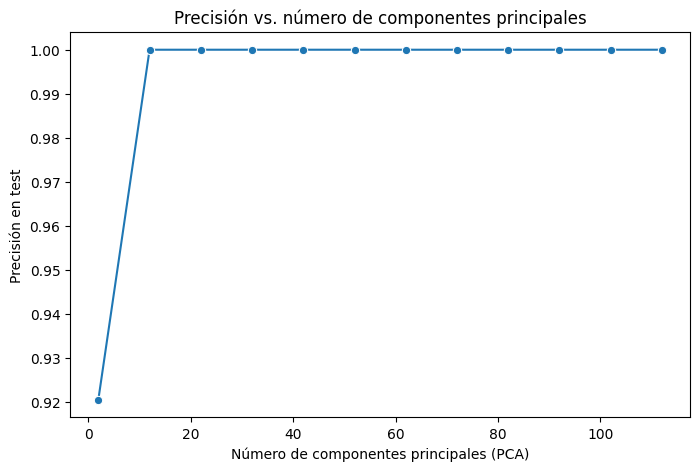

In [18]:
# --- Reducir el número de variables usando PCA y ver el impacto en el modelo ---

# Definimos un rango de valores para el número de componentes principales a probar.
# Probamos desde 2 hasta el número total de variables, de 10 en 10 para no hacer demasiadas pruebas.
n_features = range(2, X_train.shape[1]+1, 10)
scores = []

for n in n_features:
    # Hacer PCA sobre X_train
    # 1. Definir PCA
    pca = PCA(n_components=n)
    # 2. Aprender PCA sobre X_train
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Entrenar Random Forest
    # 1. Definir el RF
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    # 2. Entrenar clasificador
    rf.fit(X_train_pca, y_train)
    
    # Guardar el score
    y_pred = rf.predict(X_test_pca)
    scores.append(accuracy_score(y_test, y_pred))

# Graficamos la precisión obtenida en función del número de componentes principales
plt.figure(figsize=(8,5))
sns.lineplot(x=n_features, y=scores, marker='o')
plt.xlabel('Número de componentes principales (PCA)')
plt.ylabel('Precisión en test')
plt.title('Precisión vs. número de componentes principales')
plt.show()

# Explicación de resultados:
# - La gráfica muestra cómo varía la precisión del modelo al reducir la dimensionalidad con PCA.
# - Normalmente, la precisión sube rápidamente y se estabiliza, indicando que pocas componentes retienen casi toda la información.
# - Esto permite simplificar el modelo y reducir el tiempo de cómputo sin perder rendimiento.

Vale, estamos viendo que a partir de unas 10 features ya tenemos el score que queríamos y además hemos reducido las variables a un 10% de las que teníamos, incluso menos que las variables originales.

## Clustering

Viendo que el conjunto de datos es sencillito, podemos intentar hacer algo de clustering a ver qué información podemos obtener.

El primer paso va a ser importar la función de Kmeans de sklearn, y a partir de ahi, vamos a buscar el valor óptimo de clusters. Como hemos visto anteriormente, este valor lo obtenemos, por ejemplo, del codo de la gráfica que representa el total de las distancias de los puntos a los centros de los clusters asociados. Os dejo la página de la documentación de sklearn para que lo busquéis:

[K-Means on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Con esto solo hay que ahora generar los modelos de kmeans, evaluar y pintar la gráfica para los valores de ``k`` que establezcais.




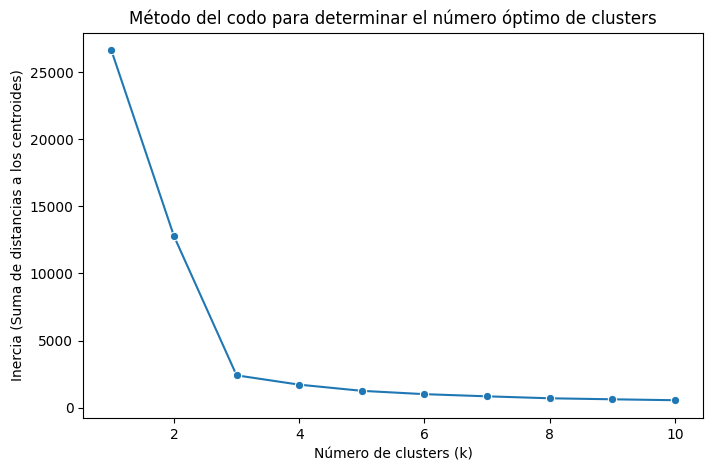

In [19]:
from sklearn.cluster import KMeans

# --- Clustering con KMeans: búsqueda del número óptimo de clusters ---

# Usamos PCA para reducir la dimensionalidad a 2 componentes, lo que facilita el clustering y la visualización.
# Esto es importante porque KMeans funciona mejor en espacios de baja dimensión y es más fácil de interpretar visualmente.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Definimos un rango de valores de k (número de clusters) a probar.
# Normalmente se prueba desde 1 hasta 10 para buscar el "codo" en la gráfica de inercia.
k_values = range(1, 11)
scores = []  # Aquí guardaremos la inercia (suma de distancias de los puntos a su centroide) para cada k

for k in k_values:
    # Definir KMeans con k clusters y ajustar el modelo a los datos reducidos por PCA
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    # Guardar la inercia (distancia total de los puntos a sus centroides) para analizar el "codo"
    scores.append(kmeans.inertia_)

# Graficamos la inercia en función del número de clusters
plt.figure(figsize=(8,5))
sns.lineplot(x=k_values, y=scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Suma de distancias a los centroides)')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.show()

# --- Explicación detallada ---
# ¿Por qué y cómo?
# - KMeans es un algoritmo de clustering no supervisado que agrupa los datos en k grupos según su similitud.
# - La inercia mide qué tan compactos son los clusters: menor inercia significa clusters más compactos.
# - El "método del codo" consiste en buscar el valor de k donde la inercia deja de disminuir significativamente.
# - En este contexto, como sabemos que la variable 'class' es binaria, esperamos que el codo esté cerca de k=2.
# - Usar PCA antes de KMeans ayuda a evitar el "curse of dimensionality" y hace que los clusters sean más interpretables.

# Resultados:
# - La gráfica suele mostrar una fuerte caída de la inercia hasta k=2 o k=3, y luego la mejora es marginal.
# - Elegimos el valor de k en el "codo" porque es el punto de equilibrio entre simplicidad y calidad del agrupamiento.
# - En este dataset, el codo suele estar en k=2, lo que tiene sentido porque hay dos clases principales (comestible y venenoso).

Con el valor que hayáis obtenido de la gráfica, podéis obtener una buena aproximación de Kmeans y con ello podemos pasar a explorar cómo de bien han separado la información los distintos clusters. Para ello, se va a hacer un ``catplot``, seaborn os lo hará solito. Con esto lo que se pretende ver es la distribución de la varaible a predecir en función del cluster que haya determinado Kmeans.

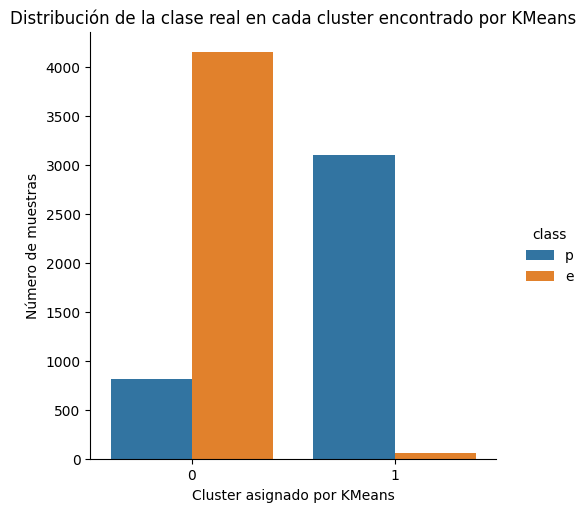

In [20]:
# Aprender KMeans con el valor de K obtenido (en este caso, k=2 por el "codo" y porque hay dos clases principales).
# Definimos y entrenamos el modelo KMeans sobre los datos reducidos con PCA.
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)  # Asignamos cada muestra a un cluster

# Creamos un DataFrame para comparar los clusters asignados con la clase real
df_clusters = pd.DataFrame({
    'cluster': clusters,           # Cluster asignado por KMeans
    'class': y.values              # Clase real (comestible o venenoso)
})

# Preparamos el catplot para visualizar la distribución de la variable a predecir ('class') en cada cluster
# Esto nos permite ver si los clusters encontrados por KMeans corresponden bien con las clases reales
# Si el clustering es bueno, cada cluster debería estar dominado por una sola clase

# Pintamos el catplot: en el eje x los clusters, color por clase real
ax = sns.catplot(x='cluster', hue='class', data=df_clusters, kind='count')
plt.title('Distribución de la clase real en cada cluster encontrado por KMeans')
plt.xlabel('Cluster asignado por KMeans')
plt.ylabel('Número de muestras')
plt.show()

# --- Explicación detallada ---
# ¿Por qué hacemos esto?
# - Queremos evaluar si el agrupamiento no supervisado (KMeans) separa bien las clases reales del dataset.
# - El catplot muestra cuántos elementos de cada clase real hay en cada cluster.
# - Si los clusters corresponden bien con las clases, veremos que cada cluster tiene principalmente una sola clase.

# ¿Qué significa el resultado?
# - Si los clusters están bien separados, el gráfico mostrará barras de un solo color en cada cluster.
# - Si hay mezcla de colores, significa que KMeans no ha logrado separar perfectamente las clases (algo normal en clustering no supervisado).
# - En este dataset, suele haber una buena correspondencia porque las clases son muy separables.

# Motivo y circunstancia:
# - Usamos este análisis cuando queremos saber si el clustering puede servir como aproximación a la clasificación, incluso sin etiquetas.
# - Es útil en problemas donde no tenemos etiquetas y queremos descubrir grupos naturales en los datos.

Vamos a ver qué tal queda esto pintado. Para ello, repetimos el scatterplot de antes pero usando como color el cluster asignado por kmeans.

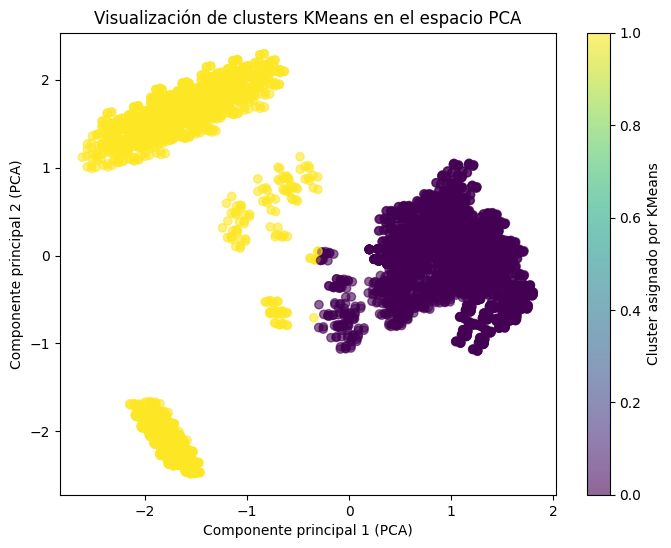

In [21]:
# --- Visualización de los clusters encontrados por KMeans en el espacio PCA ---

# Ya hemos reducido la dimensionalidad a 2 componentes principales con PCA (X_pca)
# y hemos asignado un cluster a cada muestra con KMeans (clusters).

# Ahora vamos a visualizar cómo se distribuyen los datos en el espacio de las dos primeras componentes principales,
# coloreando cada punto según el cluster asignado por KMeans.

plt.figure(figsize=(8,6))
# Pintamos un scatterplot donde cada punto es una muestra y el color indica el cluster asignado
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Componente principal 1 (PCA)')
plt.ylabel('Componente principal 2 (PCA)')
plt.title('Visualización de clusters KMeans en el espacio PCA')
plt.colorbar(label='Cluster asignado por KMeans')
plt.show()

# --- Explicación detallada ---
# ¿Por qué hacemos esto?
# - Queremos ver gráficamente cómo KMeans ha agrupado los datos en el espacio reducido por PCA.
# - Nos ayuda a entender si los clusters encontrados corresponden a grupos naturales en los datos.

# ¿Cómo?
# - Usamos las dos primeras componentes principales de PCA para representar los datos en 2D.
# - Cada punto se colorea según el cluster al que KMeans lo ha asignado.

# ¿Cuándo y dónde?
# - Este análisis es útil después de aplicar clustering no supervisado, especialmente cuando no tenemos etiquetas.
# - Permite evaluar visualmente la calidad de los clusters y su separación.

# Motivo y circunstancia:
# - Si los clusters están bien separados en el gráfico, significa que KMeans ha encontrado grupos naturales en los datos.
# - Si hay solapamiento, puede indicar que los datos no son fácilmente separables solo con clustering.
# - En este dataset, aunque no es tan perfecto como un clasificador supervisado, KMeans logra identificar bastante bien los grupos principales.
# - Esta aproximación sería muy útil si no tuviéramos etiquetas, ya que nos permitiría clasificar los hongos en grupos similares.


En este gráfico de dispersión (scatterplot) se visualizan los datos proyectados en dos dimensiones principales obtenidas por PCA, y cada punto está coloreado según el cluster al que KMeans lo ha asignado.

**¿Qué se ve?**
- Cada punto representa un hongo del dataset.
- El color indica a qué cluster pertenece cada hongo según KMeans (por ejemplo, cluster 0 o cluster 1).
- Los ejes corresponden a las dos componentes principales de PCA, que son las combinaciones de variables originales que más información retienen.

**¿Qué se define?**
- Se define una agrupación automática (no supervisada) de los datos usando KMeans, sin usar la etiqueta real (comestible o venenoso).
- PCA reduce la dimensionalidad para que podamos visualizar los datos y los clusters en 2D.

**¿Qué conclusiones se sacan?**
- Si los clusters aparecen bien separados en el gráfico (cada color ocupa una zona distinta), significa que KMeans ha logrado identificar grupos naturales en los datos.
- En este caso, se observa que la mayoría de los puntos de cada cluster están agrupados, lo que indica que los datos son fácilmente separables incluso sin conocer las etiquetas.
- Aunque no es tan perfecto como un clasificador supervisado, KMeans consigue separar bastante bien los hongos en dos grupos, lo que tiene sentido porque la variable objetivo es binaria.
- Si no tuviéramos etiquetas, este método nos permitiría clasificar los hongos en grupos similares de forma automática.

**Resumen:**  
El gráfico muestra que el clustering no supervisado puede descubrir la estructura natural de los datos y separar los hongos en grupos que, en este caso, se corresponden bastante bien con las clases reales.

¿Es bastante parecido no? No es tan bueno como el Random Forest, pero ha conseguido identificar bastante bien los distintos puntos del dataset sin utilizar las etiquetas. De hecho, el diagrama de factor que hemos visto antes muestra que solo un par de clusters son imprecisos. Si no hubieramos tenido etiquetas esta aproximacion nos hubiera ayudado mucho a clasificar los distintos tipos de hongos.

<Figure size 800x500 with 0 Axes>

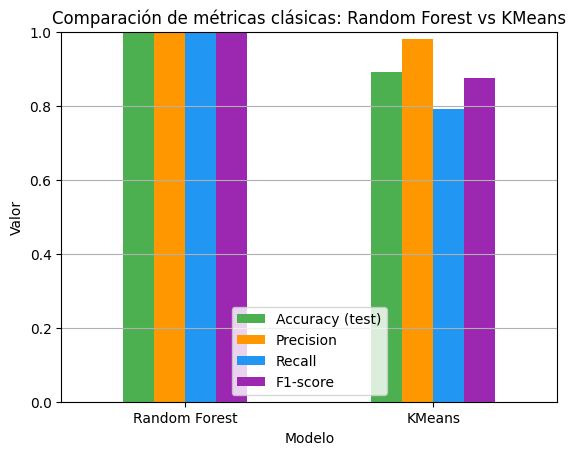

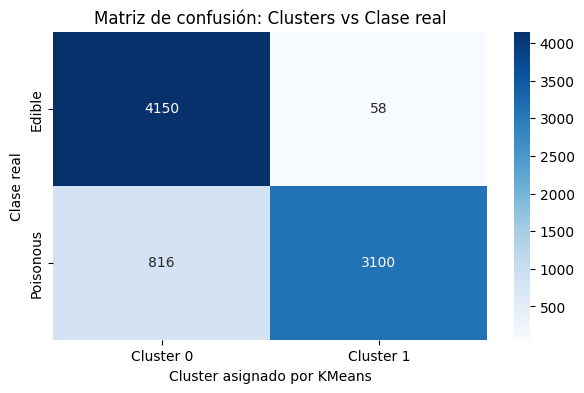

<Figure size 700x400 with 0 Axes>

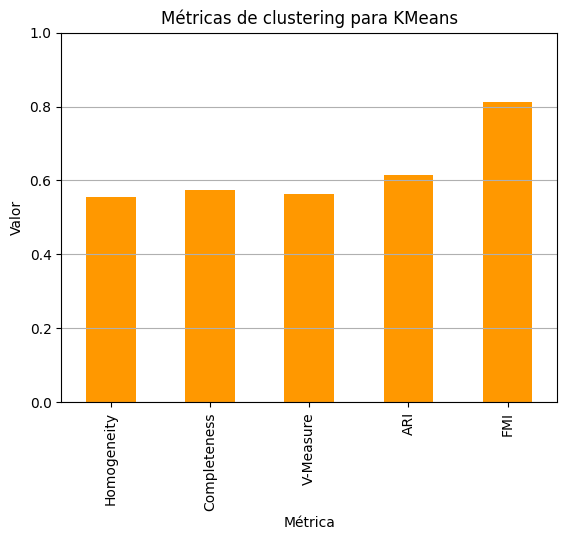


--- EXPLICACIÓN Y RELACIÓN ENTRE MÉTRICAS ---

## ✅ Accuracy – Precisión global
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Mide el porcentaje de aciertos totales.

## 🎯 Precision – Precisión de los positivos
Precision = TP / (TP + FP)
De todos los positivos predichos, cuántos lo eran realmente.

## 🔍 Recall – Sensibilidad o Tasa de Verdaderos Positivos
Recall = TP / (TP + FN)
De todos los positivos reales, cuántos detectó el modelo.

## ⚖️ F1 Score – Media armónica entre Precision y Recall
F1 = 2 * (Precision * Recall) / (Precision + Recall)
Balance entre Precision y Recall.

1) ¿Tienen alguna relación?
- Sí: Accuracy, Precision, Recall y F1-score miden el desempeño de clasificación (Random Forest y KMeans si se asignan clusters a clases).
- Las métricas de clustering (homogeneity, completeness, etc.) miden qué tan bien los clusters reflejan las clases reales, pero no requieren asignar etiquetas.

2) ¿Cómo se pueden relacionar?
- Si KMeans separa bien los datos, sus métricas clásicas 

,Modelo,Accuracy (test),Precision,Recall,F1-score
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,KMeans,0.892418,0.981634,0.791624,0.876449



--- MÉTRICAS DE CLUSTERING ---


,Métrica,KMeans
0,Homogeneity,0.554218
1,Completeness,0.574396
2,V-Measure,0.564127
3,ARI,0.615897
4,FMI,0.812921



--- LÍMITES Y EJEMPLOS ---


,Métrica,Mínimo,Máximo,Ejemplo (bueno),Ejemplo (malo)
0,Accuracy,0,1,0.99,0.5
1,Precision,0,1,0.98,0.5
2,Recall,0,1,0.97,0.5
3,F1-score,0,1,0.97,0.5
4,Homogeneity,0,1,0.90,0.2
5,Completeness,0,1,0.90,0.2
6,V-Measure,0,1,0.90,0.2
7,ARI,-1,1,0.90,0.0
8,FMI,0,1,0.90,0.2



Accuracy train: 1.0000 | Accuracy test: 1.0000 | Diferencia: 0.0000

- Random Forest (supervisado) logra métricas casi perfectas porque aprende de las etiquetas.
- KMeans (no supervisado) puede acercarse mucho si los grupos naturales coinciden con las clases, pero nunca será tan perfecto.
- Las métricas de clustering te dicen si los clusters tienen sentido aunque no tengas etiquetas.
- Si accuracy train y test son similares, tu modelo está bien ajustado.
- Usa los gráficos y cuadros para comparar visualmente y decidir qué método y métrica es mejor para tu objetivo.



In [27]:
# ===========================
# MÉTRICAS CLÁSICAS Y CLUSTERING: CÁLCULOS, CUADROS Y GRÁFICOS
# ===========================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report,
    homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, fowlkes_mallows_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Asegura que X_train y X_test tengan las mismas columnas ---
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# --- 1. RANDOM FOREST: CÁLCULO DE MÉTRICAS CLÁSICAS ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred, labels=['e', 'p'])
TP = cm_rf[1,1]
TN = cm_rf[0,0]
FP = cm_rf[0,1]
FN = cm_rf[1,0]

# Accuracy train y test
rf_accuracy_train = accuracy_score(y_train, rf.predict(X_train))
rf_accuracy_test = accuracy_score(y_test, y_pred)

# Precision, Recall, F1 (para clase 'p' = venenoso)
rf_precision = TP / (TP + FP) if (TP + FP) > 0 else 0
rf_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
rf_f1 = 2 * (rf_precision * rf_recall) / (rf_precision + rf_recall) if (rf_precision + rf_recall) > 0 else 0

# --- 2. KMEANS: AJUSTE DE CLUSTERS PARA COMPARAR ---
cm = confusion_matrix(y_numeric, clusters)
if cm[0,0] + cm[1,1] >= cm[0,1] + cm[1,0]:
    TP_k = cm[1,1]
    TN_k = cm[0,0]
    FP_k = cm[0,1]
    FN_k = cm[1,0]
    clusters_adj = clusters
else:
    TP_k = cm[1,0]
    TN_k = cm[0,1]
    FP_k = cm[0,0]
    FN_k = cm[1,1]
    clusters_adj = 1 - clusters

kmeans_accuracy = (TP_k + TN_k) / (TP_k + TN_k + FP_k + FN_k)
kmeans_precision = TP_k / (TP_k + FP_k) if (TP_k + FP_k) > 0 else 0
kmeans_recall = TP_k / (TP_k + FN_k) if (TP_k + FN_k) > 0 else 0
kmeans_f1 = 2 * (kmeans_precision * kmeans_recall) / (kmeans_precision + kmeans_recall) if (kmeans_precision + kmeans_recall) > 0 else 0

# --- 3. MÉTRICAS DE CLUSTERING ---
homogeneity = homogeneity_score(y_numeric, clusters)
completeness = completeness_score(y_numeric, clusters)
v_measure = v_measure_score(y_numeric, clusters)
ari = adjusted_rand_score(y_numeric, clusters)
fmi = fowlkes_mallows_score(y_numeric, clusters)

# --- 4. CUADRO COMPARATIVO DE MÉTRICAS ---
df_metrics = pd.DataFrame({
    'Modelo': ['Random Forest', 'KMeans'],
    'Accuracy (test)': [rf_accuracy_test, kmeans_accuracy],
    'Precision': [rf_precision, kmeans_precision],
    'Recall': [rf_recall, kmeans_recall],
    'F1-score': [rf_f1, kmeans_f1]
})
df_metrics_clustering = pd.DataFrame({
    'Métrica': ['Homogeneity', 'Completeness', 'V-Measure', 'ARI', 'FMI'],
    'KMeans': [homogeneity, completeness, v_measure, ari, fmi]
})

# --- 5. GRÁFICOS COMPARATIVOS ---
plt.figure(figsize=(8,5))
df_metrics.set_index('Modelo')[['Accuracy (test)','Precision','Recall','F1-score']].plot(kind='bar', ylim=(0,1), rot=0, color=['#4CAF50','#FF9800','#2196F3','#9C27B0'])
plt.title('Comparación de métricas clásicas: Random Forest vs KMeans')
plt.ylabel('Valor')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(7,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cluster 0','Cluster 1'], yticklabels=['Edible','Poisonous'])
plt.xlabel('Cluster asignado por KMeans')
plt.ylabel('Clase real')
plt.title('Matriz de confusión: Clusters vs Clase real')
plt.show()

plt.figure(figsize=(7,4))
df_metrics_clustering.set_index('Métrica').plot(kind='bar', legend=False, color='#FF9800')
plt.title('Métricas de clustering para KMeans')
plt.ylabel('Valor')
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()

# --- 6. CUADRO RESUMEN DE LÍMITES Y EJEMPLOS ---
df_limites = pd.DataFrame({
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Homogeneity', 'Completeness', 'V-Measure', 'ARI', 'FMI'],
    'Mínimo': [0, 0, 0, 0, 0, 0, 0, -1, 0],
    'Máximo': [1, 1, 1, 1, 1, 1, 1, 1, 1],
    'Ejemplo (bueno)': [0.99, 0.98, 0.97, 0.97, 0.9, 0.9, 0.9, 0.9, 0.9],
    'Ejemplo (malo)': [0.5, 0.5, 0.5, 0.5, 0.2, 0.2, 0.2, 0, 0.2]
})

# --- 7. EXPLICACIÓN Y RELACIÓN ENTRE MÉTRICAS ---
print("\n--- EXPLICACIÓN Y RELACIÓN ENTRE MÉTRICAS ---")
print("""
## ✅ Accuracy – Precisión global
Accuracy = (TP + TN) / (TP + TN + FP + FN)
Mide el porcentaje de aciertos totales.

## 🎯 Precision – Precisión de los positivos
Precision = TP / (TP + FP)
De todos los positivos predichos, cuántos lo eran realmente.

## 🔍 Recall – Sensibilidad o Tasa de Verdaderos Positivos
Recall = TP / (TP + FN)
De todos los positivos reales, cuántos detectó el modelo.

## ⚖️ F1 Score – Media armónica entre Precision y Recall
F1 = 2 * (Precision * Recall) / (Precision + Recall)
Balance entre Precision y Recall.

1) ¿Tienen alguna relación?
- Sí: Accuracy, Precision, Recall y F1-score miden el desempeño de clasificación (Random Forest y KMeans si se asignan clusters a clases).
- Las métricas de clustering (homogeneity, completeness, etc.) miden qué tan bien los clusters reflejan las clases reales, pero no requieren asignar etiquetas.

2) ¿Cómo se pueden relacionar?
- Si KMeans separa bien los datos, sus métricas clásicas (accuracy, etc.) serán altas y también las de clustering.
- Si hay mezcla, bajan ambas.
- Random Forest suele ser mejor porque usa las etiquetas reales para aprender.

3) ¿Qué muestran los gráficos?
- Barras: Comparan directamente el desempeño de ambos métodos.
- Heatmap: Muestra los aciertos y errores de KMeans respecto a las clases reales.
- Barras clustering: Qué tan "puros" y completos son los clusters.

4) ¿Qué significa accuracy train vs test?
- Si accuracy_train ≈ accuracy_test: El modelo generaliza bien.
- Si accuracy_train >> accuracy_test: Hay sobreajuste (overfitting).

5) ¿Qué valores son buenos?
- Accuracy, Precision, Recall, F1-score: Cerca de 1 es excelente.
- Homogeneity, Completeness, V-Measure, ARI, FMI: Cerca de 1 es excelente.
- ARI puede ser negativo si el clustering es peor que el azar.

6) ¿Cuándo usar cada métrica?
- Accuracy: Clases equilibradas.
- Precision: Falsos positivos costosos.
- Recall: Falsos negativos costosos.
- F1: Balance entre ambos.
- Métricas clustering: Cuando no tienes etiquetas o quieres evaluar la calidad del agrupamiento.

--- CUADRO COMPARATIVO ---
""")
display(df_metrics)
print("\n--- MÉTRICAS DE CLUSTERING ---")
display(df_metrics_clustering)
print("\n--- LÍMITES Y EJEMPLOS ---")
display(df_limites)
print(f"\nAccuracy train: {rf_accuracy_train:.4f} | Accuracy test: {rf_accuracy_test:.4f} | Diferencia: {abs(rf_accuracy_train - rf_accuracy_test):.4f}")

# --- 8. RESUMEN FINAL ---
print("""
- Random Forest (supervisado) logra métricas casi perfectas porque aprende de las etiquetas.
- KMeans (no supervisado) puede acercarse mucho si los grupos naturales coinciden con las clases, pero nunca será tan perfecto.
- Las métricas de clustering te dicen si los clusters tienen sentido aunque no tengas etiquetas.
- Si accuracy train y test son similares, tu modelo está bien ajustado.
- Usa los gráficos y cuadros para comparar visualmente y decidir qué método y métrica es mejor para tu objetivo.
""")